# Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import *

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is Enabled")
    
import keract
import networkx as nx
from collections import deque, defaultdict
from sklearn import preprocessing
import re
from typing import TypedDict, Optional
from pprint import pprint
from grandalf.layouts import SugiyamaLayout
import grandalf

# import onnx
# from onnx_tf.backend import prepare
# from onnx2keras import onnx_to_keras
# from onnx2tf import convert


2023-02-06 02:23:00.064213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 02:23:00.600546: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-06 02:23:00.600579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-06 02:23:00.600583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

GPU is Enabled


2023-02-06 02:23:01.708665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:23:01.713083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:23:01.713341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Dataset

2023-02-06 02:23:02.558880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 02:23:02.559395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:23:02.559602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:23:02.559744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

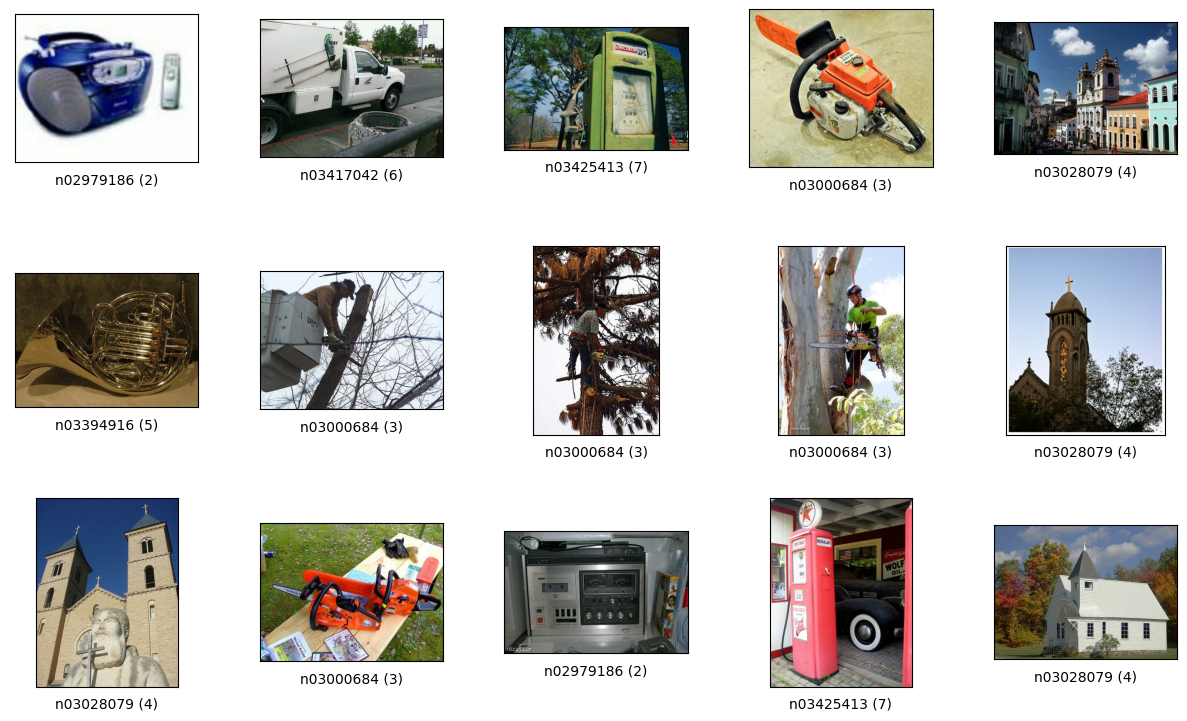

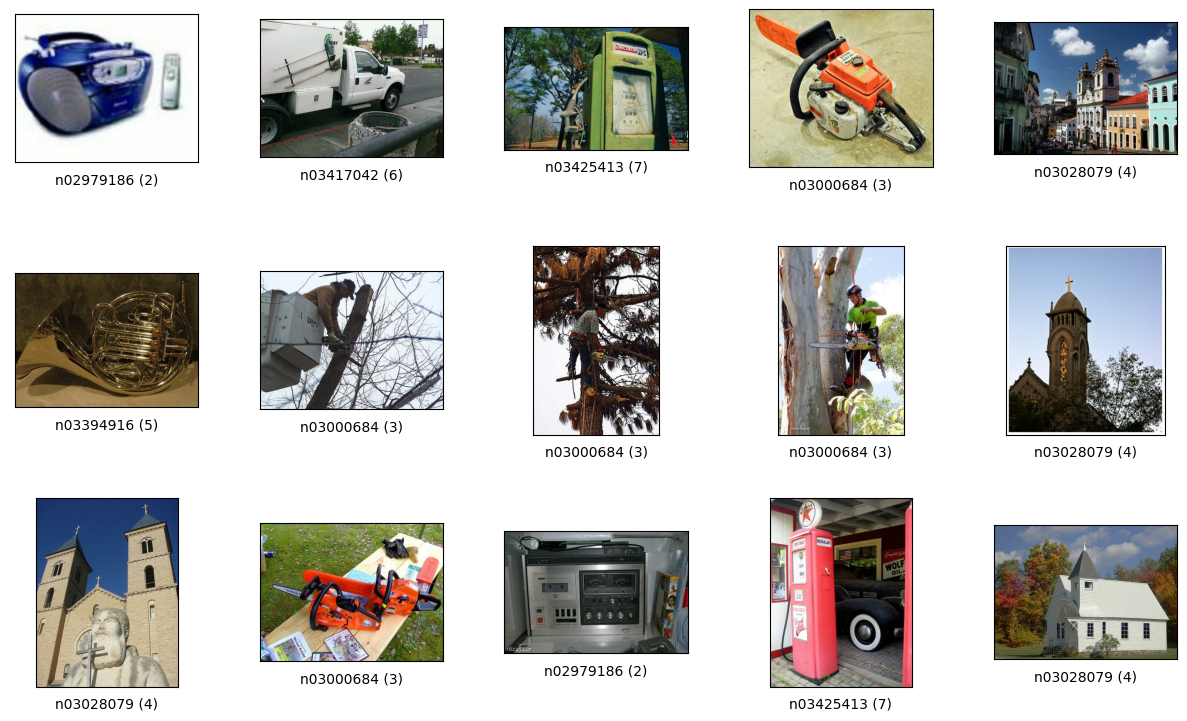

In [2]:
ds_and_info : tuple[defaultdict, tfds.core.DatasetInfo] = tfds.load(
    'imagenette/320px-v2', 
    shuffle_files=False, 
    with_info=True,
    as_supervised=True,
    batch_size=None,
)

ds, ds_info = ds_and_info

tfds.show_examples(ds['train'], ds_info, cols=5)

# Inception V3

![Inceptionv3_architecture.png](Inceptionv3_architecture.png)

In [3]:
inception_v3 = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet'
)

In [4]:
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [5]:
# inception_v3.save('inception_v3')

In [6]:
tf.keras.utils.plot_model(
    inception_v3, 
    show_shapes=True,
    # show_dtype=True,
    # expand_nested=True,
    show_layer_activations=True
)

# Get Activation Pathways

In [7]:
activation_pathway_full = model_to_graph(inception_v3)

In [8]:
names = set()

for node, node_data in activation_pathway_full.nodes(data=True):
    names.add(node_data['layer_type'])

names

{'Activation',
 'AveragePooling2D',
 'BatchNormalization',
 'Concatenate',
 'Conv2D',
 'Dense',
 'GlobalAveragePooling2D',
 'InputLayer',
 'MaxPooling2D'}

In [9]:
simple_activation_pathway_full = remove_intermediate_node(activation_pathway_full, lambda node: activation_pathway_full.nodes[node]['layer_type'] not in ['Conv2D', 'Dense', 'InputLayer', 'Concatenate'])

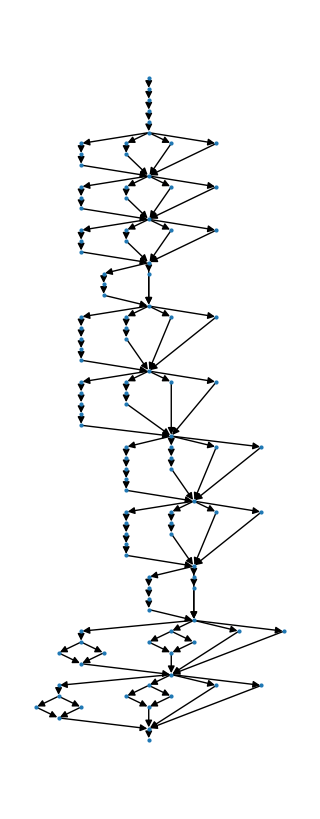

In [10]:
def get_model_layout(G):
    # TODO: Work on getting a better layout

    # Naive layout
    # pos = {}
    # input_node, _ = next(node for node in G.nodes(data=True) if node[1]['layer_type'] == 'InputLayer')
    # G.nodes[input_node]['level'] = 0
    # tree_depth = 0
    # for node in nx.topological_sort(G):
    #     if G.nodes[node]['layer_type'] == 'InputLayer':
    #         continue
    #     level = max(
    #         G.nodes[predecessor]['level'] 
    #         for predecessor in G.predecessors(node)
    #     ) + 1
    #     G.nodes[node]['level'] = level
    #     tree_depth = max(tree_depth, level)
    # pos = nx.multipartite_layout(G, subset_key="level", align='horizontal', scale=-1)


    # Get nodes by level
    # nodes_by_level = [[] for tree_depth in range(tree_depth + 1)]

    # for node, node_data in simple_activation_pathway_full.nodes(data=True):
    #     nodes_by_level[node_data['level']].append(node)

    # [[nx.get_node_attributes(simple_activation_pathway_full, 'name')[node] for node in nodes] for nodes in nodes_by_level]


    # Sugiyama Layout from grandalf library
    g = grandalf.utils.convert_nextworkx_graph_to_grandalf(G)
    for v in g.V(): v.view = type("defaultview", (object,), {"w": 10, "h": 10})
    sug = SugiyamaLayout(g.C[0])
    sug.init_all()
    sug.draw() # This only calculated the positions for each node.
    pos = {v.data: (v.view.xy[0], -v.view.xy[1]) for v in g.C[0].sV} # Extracts the positions
    return pos

plt.figure(figsize=(3,8))
nx.draw(simple_activation_pathway_full, pos=get_model_layout(simple_activation_pathway_full), node_size=4)
plt.show()

# Preprocessing

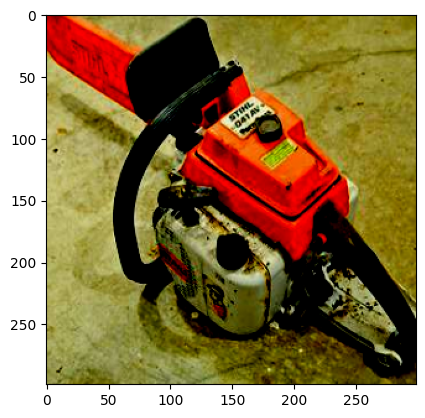

In [11]:
example_img, example_label = get_example(ds['train'])

example_img = preprocess(example_img, size=inception_v3.input.shape[1:3].as_list())
plt.imshow(example_img)

# Test Model Prediction

In [12]:
input_img: np.ndarray = tf.reshape(example_img, [1, *example_img.shape]).numpy()
pred: tf.Tensor = inception_v3(input_img)

print('Predicted', pred_to_name(tf.math.argmax(pred[0]).numpy()))
print('True', class_id_to_name(ds_info.features['label'].names[example_label]))

2023-02-06 02:23:10.803405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-02-06 02:23:10.803465: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1152 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Exception encountered when calling layer 'conv2d' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} DNN library is not found. [Op:Conv2D]

Call arguments received by layer 'conv2d' (type Conv2D):
  • inputs=tf.Tensor(shape=(1, 299, 299, 3), dtype=float32)

# Get each layer output

In [ ]:
inception_v3.compile(loss="categorical_crossentropy", optimizer="adam")

# layers = ['conv2d_6', 'conv2d_93']
layers = None

activations = keract.get_activations(inception_v3, input_img, layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)


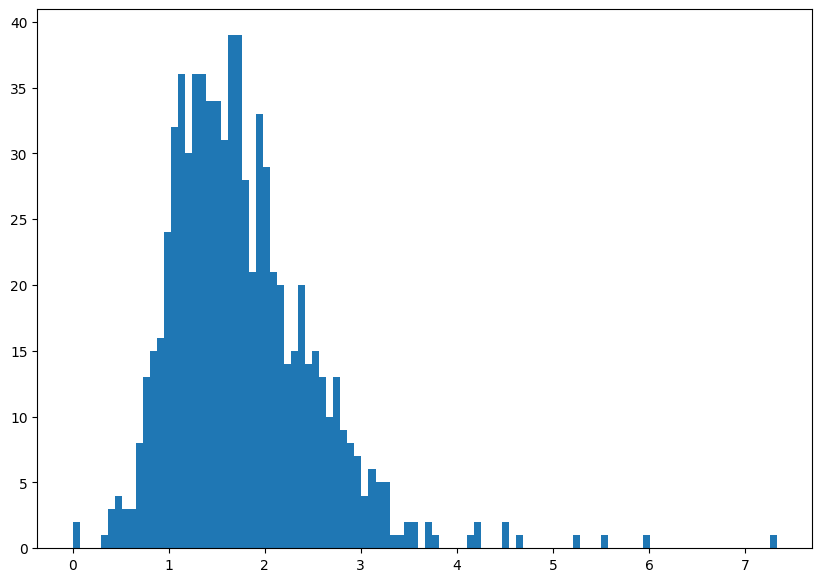

In [ ]:
summary_fn = lambda x, axis: np.percentile(x, 95, axis=axis)
summary = summary_fn(np.abs(activations['mixed3'][0]), axis=(0, 1))

# Plot distrubution of summary
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(summary, bins=100)
plt.show()

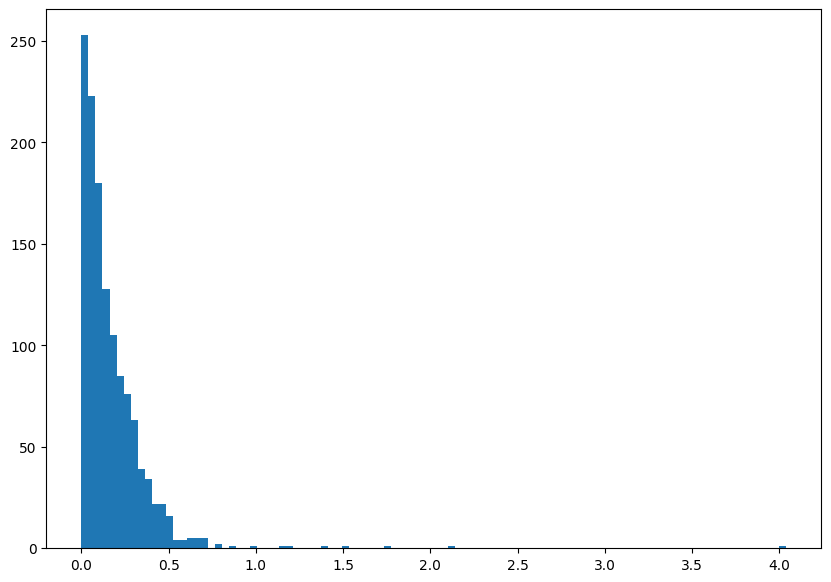

In [ ]:
summary_fn = np.mean
summary = summary_fn(np.abs(activations['mixed8'][0]), axis=(0, 1))

# Plot distrubution of summary
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(summary, bins=100)
plt.show()

In [ ]:
activations.keys()

odict_keys(['input_1', 'conv2d', 'batch_normalization', 'activation', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'max_pooling2d', 'conv2d_3', 'batch_normalization_3', 'activation_3', 'conv2d_4', 'batch_normalization_4', 'activation_4', 'max_pooling2d_1', 'conv2d_8', 'batch_normalization_8', 'activation_8', 'conv2d_6', 'conv2d_9', 'batch_normalization_6', 'batch_normalization_9', 'activation_6', 'activation_9', 'average_pooling2d', 'conv2d_5', 'conv2d_7', 'conv2d_10', 'conv2d_11', 'batch_normalization_5', 'batch_normalization_7', 'batch_normalization_10', 'batch_normalization_11', 'activation_5', 'activation_7', 'activation_10', 'activation_11', 'mixed0', 'conv2d_15', 'batch_normalization_15', 'activation_15', 'conv2d_13', 'conv2d_16', 'batch_normalization_13', 'batch_normalization_16', 'activation_13', 'activation_16', 'average_pooling2d_1', 'conv2d_12', 'conv2d_14', 'conv2d_17', 'conv2d_18', 'batch_normalization_12', 'batc

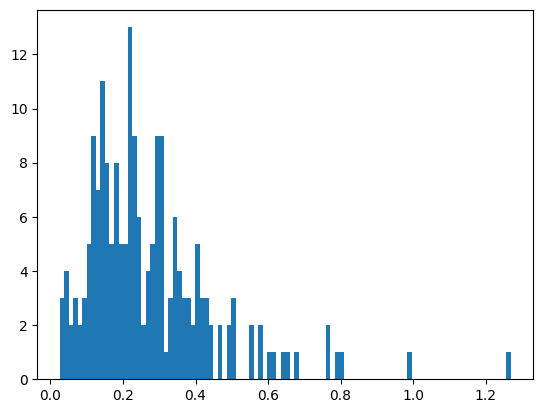

/tmp/ipykernel_75668/1095748146.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)


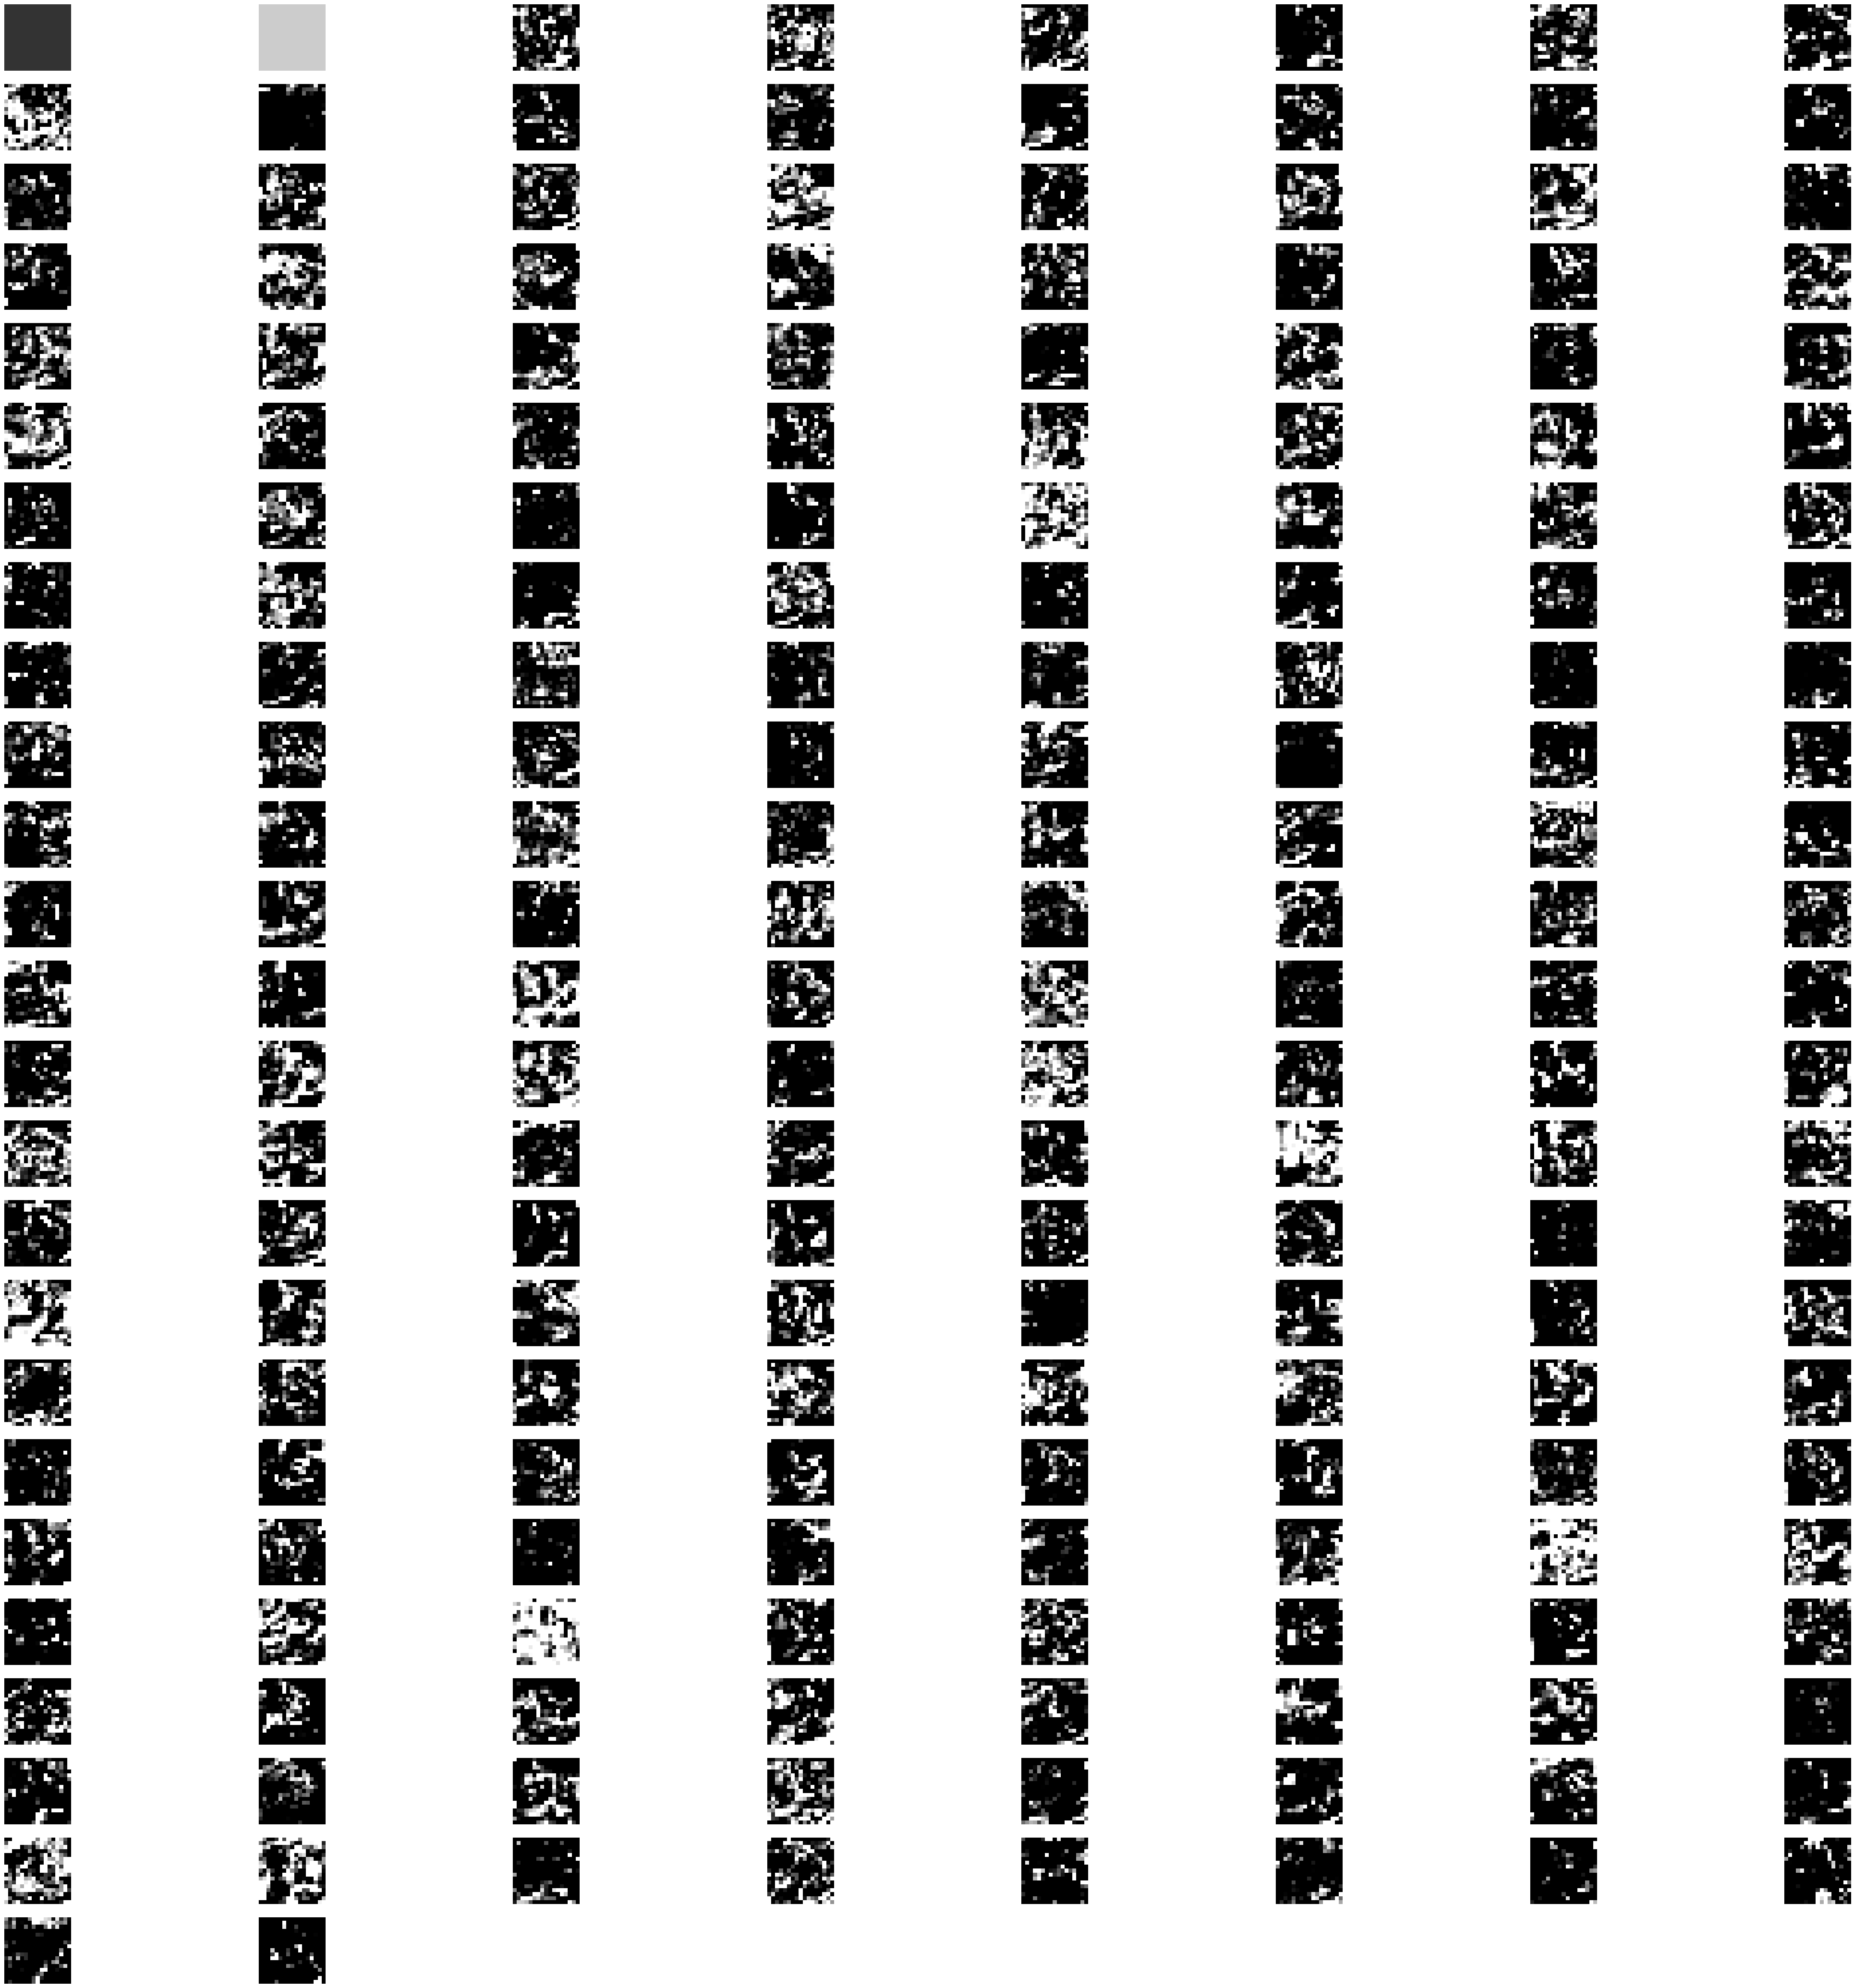

In [ ]:
layer = 'activation_50'
nrows = 8
cur_activations = np.abs(activations[layer])
# cur_activations = (cur_activations - cur_activations.min()) / (cur_activations.max() - cur_activations.min())
cur_activations = (cur_activations - np.percentile(cur_activations, 10)) / (np.percentile(cur_activations, 90) - np.percentile(cur_activations, 10))
cur_activations = np.concatenate([(np.ones((*cur_activations.shape[:3],1))*0.2), (np.ones((*cur_activations.shape[:3],1))*0.8), cur_activations], axis=3)
plt.hist(cur_activations.mean(axis=(0, 1, 2)), bins=100)
plt.show()
# Plot all the images from layer in grid with nrows columns
fig, ax = plt.subplots(figsize=(60, 60))
for i in range(cur_activations.shape[3]):
    ax = plt.subplot(cur_activations.shape[3] // nrows + 1, nrows, i+1)
    ax.imshow(
        cur_activations[0,:,:,i],
        interpolation='nearest',
        cmap='gray',
        vmin=0,
        vmax=1,
    )
    ax.axis('off')
plt.show()


activation_50 (1, 17, 17, 192) 


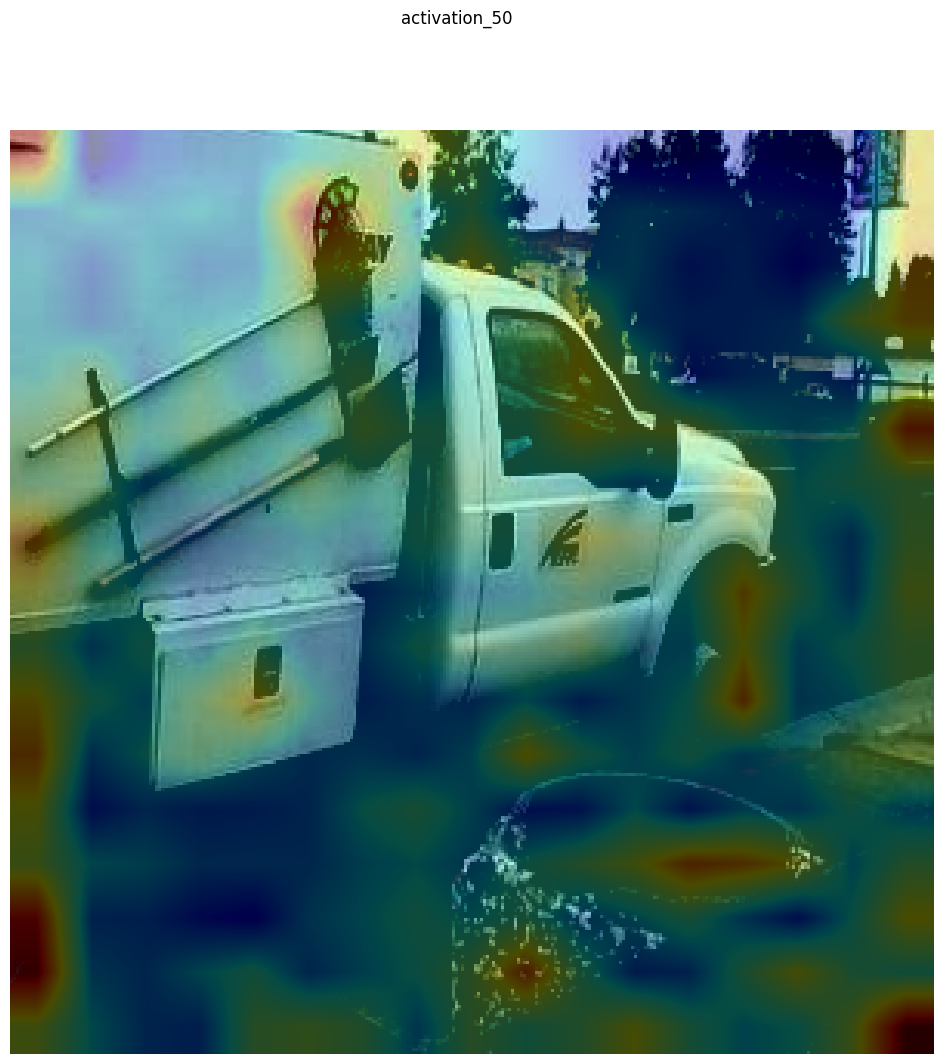

In [ ]:
keract.display_heatmaps({layer: activations[layer]}, input_img[0], fix=False, merge_filters=True)

# Filtering activation layers

In [ ]:
cur_activations.shape

(1, 17, 17, 194)

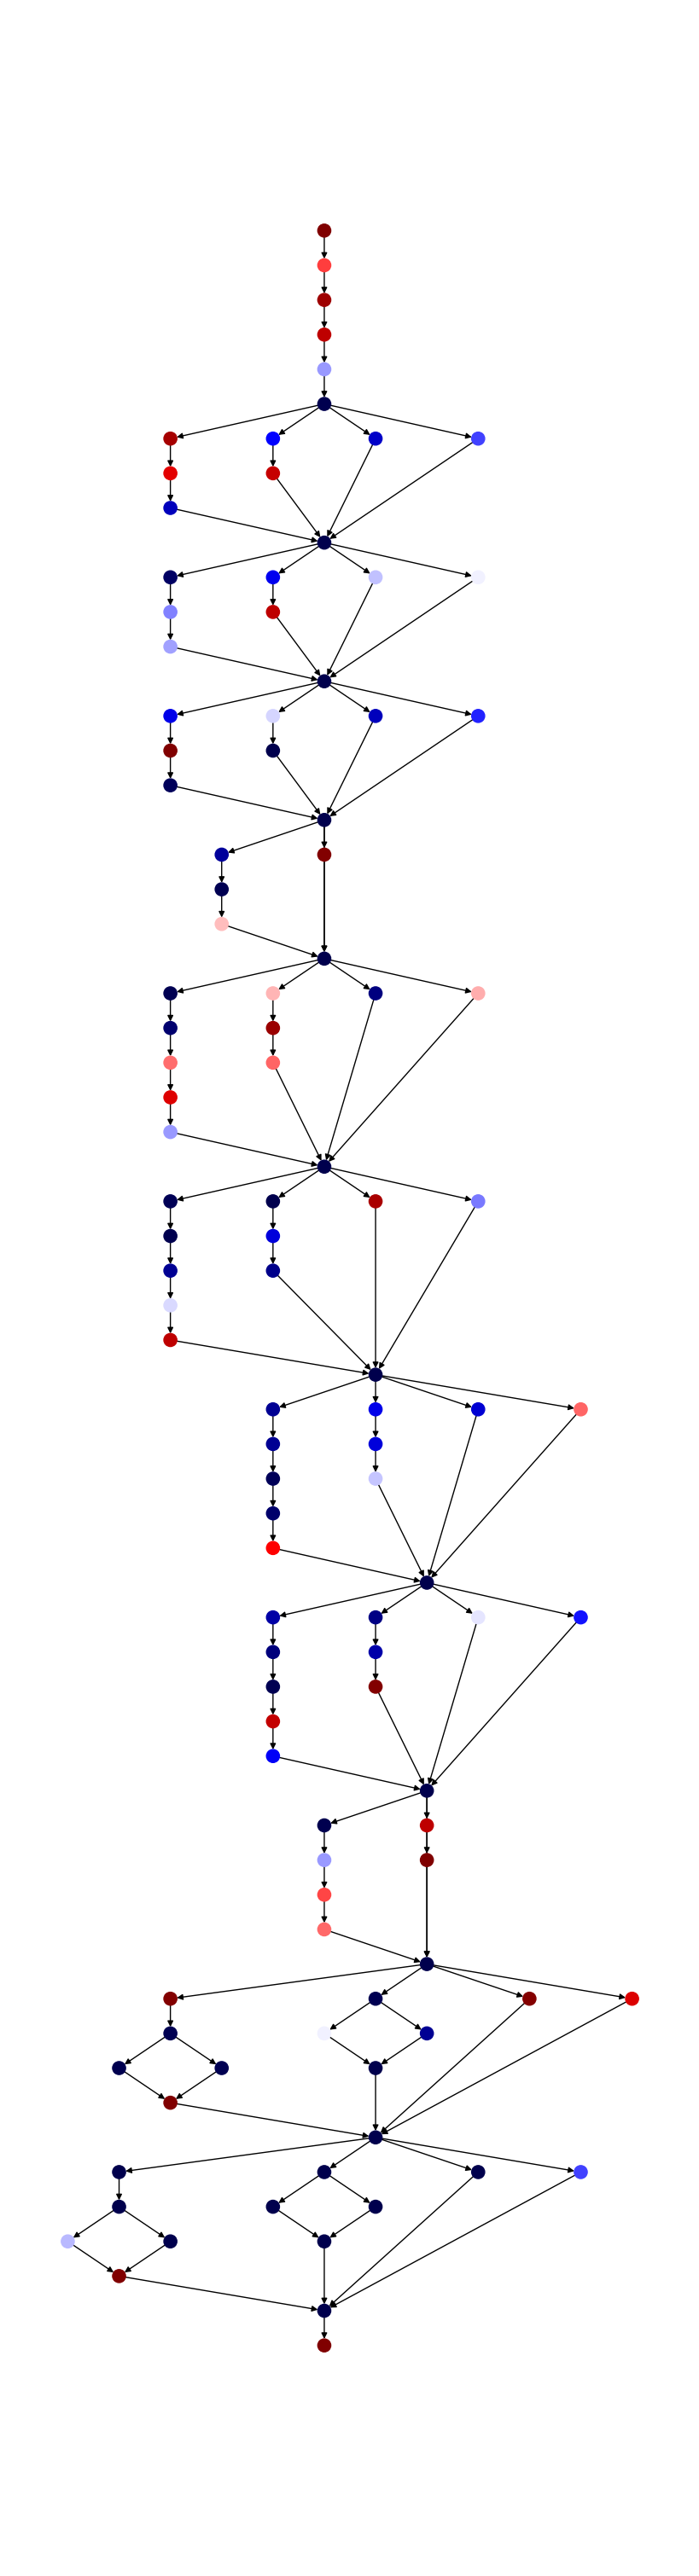

In [ ]:
THRESHOLD = 0.5
TOP_BOT_CUT = 0
summary_fn = lambda x: np.mean(x, axis=(0, 1, 2))

simple_activation_pathway_full_img1 = simple_activation_pathway_full.copy()

for node, data in simple_activation_pathway_full_img1.nodes(data=True):
    if 'conv' in data['name'] or 'mixed' in data['name']:
        cur_activations = activations[data['name']]
        cur_activations = np.clip((cur_activations - np.percentile(cur_activations, TOP_BOT_CUT)) / (np.percentile(cur_activations, 100 - TOP_BOT_CUT) - np.percentile(cur_activations, TOP_BOT_CUT)), 0, 1)
        # cur_activations = np.concatenate([(np.ones((*cur_activations.shape[:3],1))*0.2), (np.ones((*cur_activations.shape[:3],1))*0.8), cur_activations], axis=3)
        values = summary_fn(cur_activations)

        dynamic_threshold = np.percentile(values, 100 * THRESHOLD)

        # values = values > dynamic_threshold
        values = values > THRESHOLD

        simple_activation_pathway_full_img1.nodes[node]['activated'] = values
    else:
        simple_activation_pathway_full_img1.nodes[node]['activated'] = np.array([True])


plt.figure(figsize=(8,30))
activated_count = np.array([data['activated'].sum()/len(data['activated']) for node, data in simple_activation_pathway_full_img1.nodes(data=True)])
activated_count = (activated_count - activated_count.min()) / (activated_count.max() - activated_count.min())

cmap = list(map(mpl.colormaps['seismic'], activated_count))
nx.draw(
    simple_activation_pathway_full_img1,
    pos=get_model_layout(simple_activation_pathway_full_img1),
    node_size=120,
    node_color=cmap,
    # labels=nx.get_node_attributes(simple_activation_pathway_full_img1, 'name'),
    # connectionstyle="arc3,rad=0.1"
)
plt.show()

In [ ]:
[f"{data['name']}   {data['activated'].sum()}/{len(data['activated'])}" for node, data in simple_activation_pathway_full_img1.nodes(data=True) if 'activated' in data]

['input_1   1/1',
 'conv2d   22/32',
 'conv2d_1   30/32',
 'conv2d_2   56/64',
 'conv2d_3   32/80',
 'conv2d_4   1/192',
 'conv2d_8   59/64',
 'conv2d_6   12/48',
 'conv2d_9   77/96',
 'conv2d_5   11/64',
 'conv2d_7   55/64',
 'conv2d_10   15/96',
 'conv2d_11   10/32',
 'mixed0   0/256',
 'conv2d_15   2/64',
 'conv2d_13   11/48',
 'conv2d_16   36/96',
 'conv2d_12   28/64',
 'conv2d_14   56/64',
 'conv2d_17   39/96',
 'conv2d_18   31/64',
 'mixed1   0/288',
 'conv2d_22   14/64',
 'conv2d_20   22/48',
 'conv2d_23   96/96',
 'conv2d_19   10/64',
 'conv2d_21   0/64',
 'conv2d_24   2/96',
 'conv2d_25   18/64',
 'mixed2   0/288',
 'conv2d_27   7/64',
 'conv2d_28   1/96',
 'conv2d_26   381/384',
 'conv2d_29   54/96',
 'mixed3   0/768',
 'conv2d_34   1/128',
 'conv2d_35   6/128',
 'conv2d_31   73/128',
 'conv2d_36   82/128',
 'conv2d_32   121/128',
 'conv2d_37   104/128',
 'conv2d_30   14/192',
 'conv2d_33   125/192',
 'conv2d_38   77/192',
 'conv2d_39   111/192',
 'mixed4   0/768',
 'conv2d_4

In [ ]:
def compare_activation_layer(layer1_activation_summary, layer2_activation_summary):
    return np.sqrt(((layer1_activation_summary - layer2_activation_summary)*(layer1_activation_summary - layer2_activation_summary)).sum())

In [ ]:
compare_activation_layer(summary_fn(activations['conv2d_10']), summary_fn(activations['conv2d_10']))

0.0

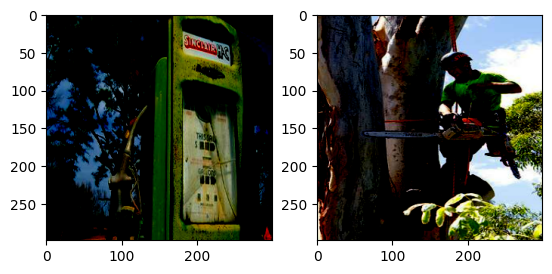

7 3


In [ ]:
example_img1, example_label1 = get_example(ds['train'])
example_img2, example_label2 = get_example(ds['train'])

example_img1 = preprocess(example_img1, size=inception_v3.input.shape[1:3].as_list())
example_img2 = preprocess(example_img2, size=inception_v3.input.shape[1:3].as_list())
plt.subplot(121)
plt.imshow(example_img1)
plt.subplot(122)
plt.imshow(example_img2)
plt.show()

print(example_label1, example_label2)

218.91578736901283


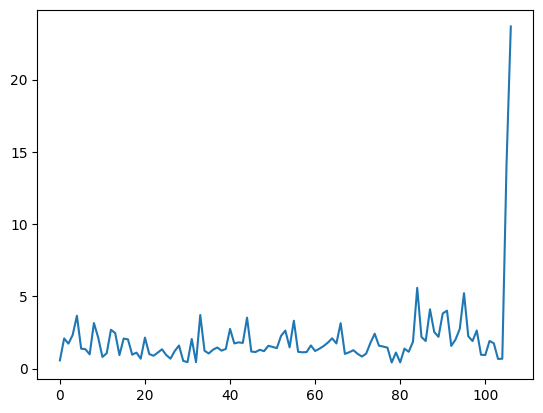

In [ ]:
layers = None

activations1 = keract.get_activations(inception_v3, np.array([example_img1]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
activations2 = keract.get_activations(inception_v3, np.array([example_img2]), layer_names=layers, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)

# summary_fn = lambda x: np.percentile(np.abs(x), 95, axis=(0,1,2))
summary_fn = lambda x: np.mean(np.abs(x), axis=(0,1,2))

dist = {f"{i_name}-{j_name}": compare_activation_layer(summary_fn(layer_i), summary_fn(layer_j)) for i_name, layer_i in activations1.items() for j_name, layer_j in activations2.items() if ('conv' in i_name or 'mixed' in i_name) and i_name == j_name}

plt.plot(dist.values())
print(sum(dist.values()))

In [ ]:
activations1['mixed10'].shape

(1, 8, 8, 2048)

In [ ]:
dist

{'conv2d-conv2d': 0.734773367717923,
 'conv2d_1-conv2d_1': 3.821219375813666,
 'conv2d_2-conv2d_2': 4.482161771226276,
 'conv2d_3-conv2d_3': 5.4126827713613865,
 'conv2d_4-conv2d_4': 7.393704148334895,
 'conv2d_8-conv2d_8': 3.4209269034369,
 'conv2d_6-conv2d_6': 2.984204820261335,
 'conv2d_9-conv2d_9': 2.0821198637388747,
 'conv2d_5-conv2d_5': 4.709828800238793,
 'conv2d_7-conv2d_7': 6.179701081582346,
 'conv2d_10-conv2d_10': 1.9432940218451256,
 'conv2d_11-conv2d_11': 1.4903965173803164,
 'mixed0-mixed0': 5.776059766969419,
 'conv2d_15-conv2d_15': 3.453332346682945,
 'conv2d_13-conv2d_13': 2.3398077278763525,
 'conv2d_16-conv2d_16': 4.351423074906083,
 'conv2d_12-conv2d_12': 3.780825566750936,
 'conv2d_14-conv2d_14': 2.0989513392878334,
 'conv2d_17-conv2d_17': 2.015798785199469,
 'conv2d_18-conv2d_18': 1.1854747268025065,
 'mixed1-mixed1': 5.904820073297976,
 'conv2d_22-conv2d_22': 1.5058600835313765,
 'conv2d_20-conv2d_20': 1.3689351454841732,
 'conv2d_23-conv2d_23': 2.78797871919041